# Wojciech Labedz, Urszula Kostuch - projekt 6

### zad za 4 pkt

In [ ]:
import glob
import os
import time
import numpy as np

import gymnasium as gym
from sb3_contrib import MaskablePPO
from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy
from sb3_contrib.common.wrappers import ActionMasker

import pettingzoo.utils
from pettingzoo.classic import connect_four_v3

import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback


class SB3ActionMaskWrapper(pettingzoo.utils.BaseWrapper, gym.Env):
    def reset(self, seed=None, options=None):
        super().reset(seed, options)

        self.observation_space = super().observation_space(self.possible_agents[0])[
            "observation"
        ]
        self.action_space = super().action_space(self.possible_agents[0])

        return self.observe(self.agent_selection), {}

    def step(self, action):
        current_agent = self.agent_selection

        super().step(action)

        next_agent = self.agent_selection
        return (
            self.observe(next_agent),
            self._cumulative_rewards[current_agent],
            self.terminations[current_agent],
            self.truncations[current_agent],
            self.infos[current_agent],
        )

    def observe(self, agent):
        return super().observe(agent)["observation"]

    def action_mask(self):
        return super().observe(self.agent_selection)["action_mask"]


def mask_fn(env):
    return env.action_mask()


class RewardLoggingCallback(BaseCallback):
    def __init__(self):
        super().__init__()
        self.episode_rewards = []

    def _on_step(self) -> bool:
        infos = self.locals.get("infos")
        if infos is not None:
            for info in infos:
                if info and "episode" in info:
                    self.episode_rewards.append(info["episode"]["r"])
        return True


def train_action_mask(env_fn, steps=10_000, seed=0, **env_kwargs):
    env = env_fn.env(**env_kwargs)

    print(f"Starting training on {str(env.metadata['name'])}.")

    env = SB3ActionMaskWrapper(env)

    env.reset(seed=seed)
    env = ActionMasker(env, mask_fn)

    model = MaskablePPO(
        MaskableActorCriticPolicy,
        env,
        verbose=1,
        learning_rate=0.00005,
        n_steps=64,
        batch_size=64
    )
    model.set_random_seed(seed)
    reward_logger = RewardLoggingCallback()
    model.learn(total_timesteps=steps, callback=reward_logger)
    model.save(f"{env.unwrapped.metadata.get('name')}")

    print("Model has been saved.")
    print(f"Finished training on {str(env.unwrapped.metadata['name'])}.\n")

    env.close()


def eval_action_mask(env_fn, num_games=100, render_mode=None, **env_kwargs):
    env = env_fn.env(render_mode=render_mode, **env_kwargs)

    print(
        f"Starting evaluation vs a random agent. Trained agent will play as {env.possible_agents[1]}."
    )

    try:
        latest_policy = max(
            glob.glob(f"{env.metadata['name']}*.zip"), key=os.path.getctime
        )
    except ValueError:
        print("Policy not found.")
        exit(0)

    model = MaskablePPO.load(latest_policy)

    scores = {agent: 0 for agent in env.possible_agents}
    total_rewards = {agent: 0 for agent in env.possible_agents}
    round_rewards = []
    rewards_per_episode = {agent: [] for agent in env.possible_agents}

    for i in range(num_games):
        env.reset(seed=i)
        env.action_space(env.possible_agents[0]).seed(i)

        episode_rewards = {agent: 0 for agent in env.possible_agents}

        for agent in env.agent_iter():
            obs, reward, termination, truncation, info = env.last()
            observation, action_mask = obs.values()

            if termination or truncation:
                if (
                    env.rewards[env.possible_agents[0]]
                    != env.rewards[env.possible_agents[1]]
                ):
                    winner = max(env.rewards, key=env.rewards.get)
                    scores[winner] += env.rewards[winner]
                for a in env.possible_agents:
                    total_rewards[a] += env.rewards[a]
                    episode_rewards[a] += env.rewards[a]
                round_rewards.append(env.rewards)
                break
            else:
                if agent == env.possible_agents[0]:
                    act = env.action_space(agent).sample(action_mask)
                else:
                    act = int(
                        model.predict(
                            observation, action_masks=action_mask, deterministic=True
                        )[0]
                    )
            env.step(act)
            for a in env.possible_agents:
                episode_rewards[a] += env.rewards[a]

        for a in env.possible_agents:
            rewards_per_episode[a].append(episode_rewards[a])

    env.close()

    plt.figure(figsize=(10, 5))

    def moving_average(data, window_size=70):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

    trained_rewards = rewards_per_episode[env.possible_agents[1]]
    random_rewards = rewards_per_episode[env.possible_agents[0]]

    plt.plot(moving_average(trained_rewards), label="Trained agent (PPO) - 10 ep avg")
    plt.plot(moving_average(random_rewards), label="Random agent - 10 ep avg")
    plt.xlabel("Episode")
    plt.ylabel("Reward (10-ep average)")
    plt.title("Smoothed Reward per Episode: PPO vs Random agent")
    plt.legend()
    plt.grid(True)
    plt.show()


    plt.figure(figsize=(10, 5))
    plt.plot(np.cumsum(rewards_per_episode[env.possible_agents[1]]), label="Trained agent (PPO) - Total reward")
    plt.plot(np.cumsum(rewards_per_episode[env.possible_agents[0]]), label="Random agent - Total reward")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Total Reward per agent")
    plt.legend()
    plt.grid(True)
    plt.show()

    if sum(scores.values()) == 0:
        winrate = 0
    else:
        winrate = scores[env.possible_agents[1]] / sum(scores.values())
    print("Rewards by round: ", round_rewards)
    print("Total rewards: ", total_rewards)
    print("Winrate: ", winrate)
    print("Final scores: ", scores)
    return round_rewards, total_rewards, winrate, scores

Starting training on connect_four_v3.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | 1        |
| time/              |          |
|    fps             | 1723     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 64       |
---------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 25.2          |
|    ep_rew_mean          | 1             |
| time/                   |               |
|    fps                  | 720           |
|    iterations           | 2             |
|    time_elapsed         | 0             |
|    total_timesteps      | 128           |
| train/                  |               |
|    approx_kl            | 1.3480894e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | -1.46         |
|    learning_rate        | 5e-05         |
|    loss                 | 0.139         |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.00156      |
|    value_loss           | 0.313         |
-------------------------------------------
------------------------------------------
| rollout/                |      

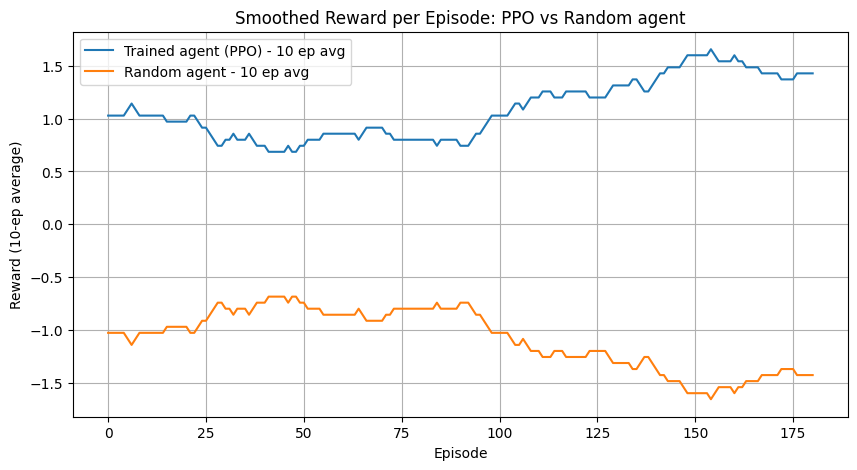

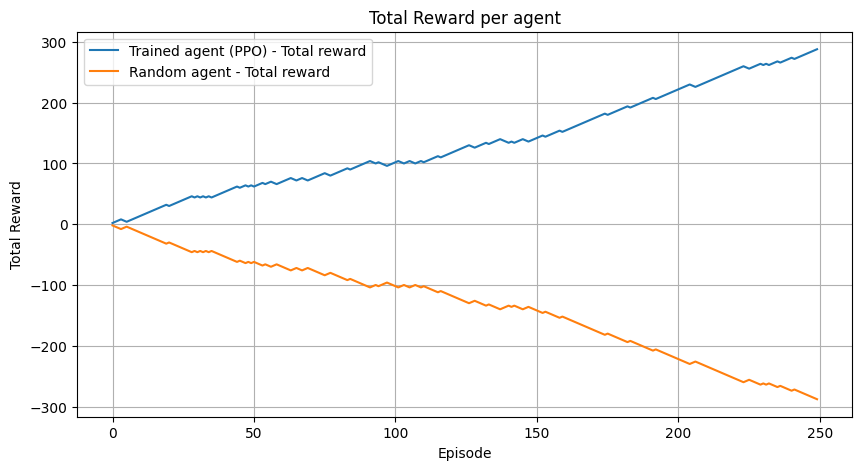

Rewards by round:  [{'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': 1, 'player_1': -1}, {'player_0': 1, 'player_1': -1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': 1, 'player_1': -1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': 1, 'player

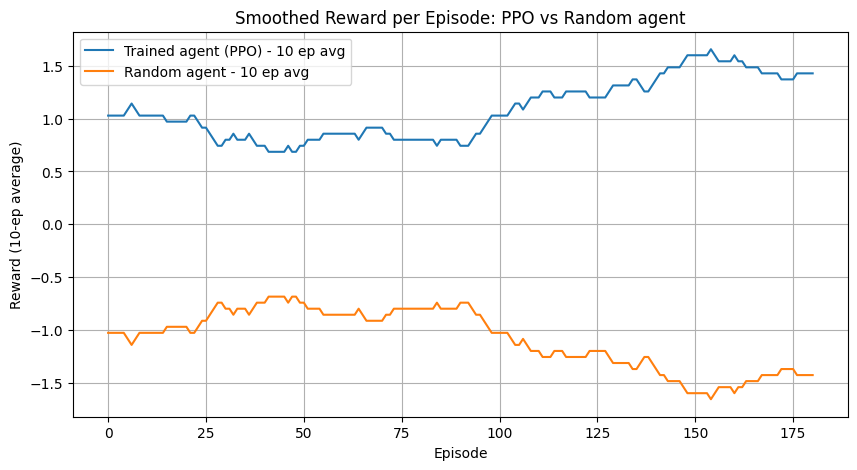

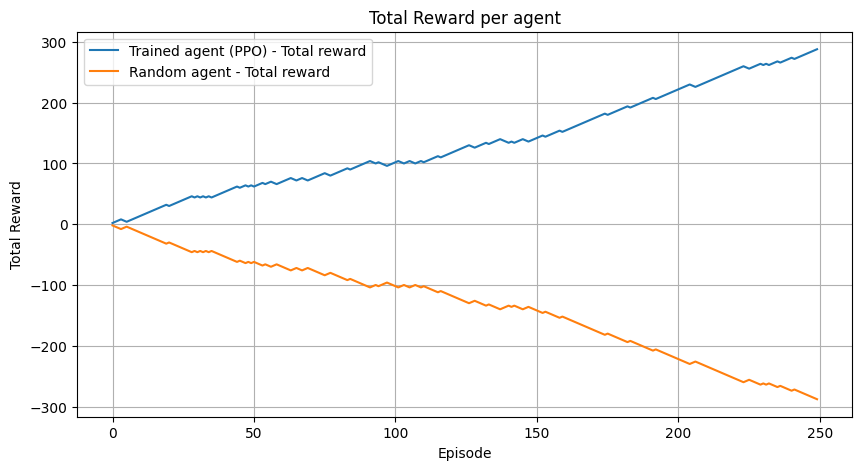

Rewards by round:  [{'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': 1, 'player_1': -1}, {'player_0': 1, 'player_1': -1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': 1, 'player_1': -1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': -1, 'player_1': 1}, {'player_0': 1, 'player

([{'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': 1, 'player_1': -1},
  {'player_0': 1, 'player_1': -1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': 1, 'player_1': -1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, 'player_1': 1},
  {'player_0': -1, '

In [ ]:
env_fn = connect_four_v3
env_kwargs = {}
train_action_mask(env_fn, steps=10_000, seed=0, **env_kwargs)
eval_action_mask(env_fn, num_games=250, render_mode=None, **env_kwargs)
eval_action_mask(env_fn, num_games=250, render_mode="human", **env_kwargs)

### zad za 8 pkt


--- Runda 1 ---
Zagrane karty: agent_0 -> 17, agent_1 -> 14
Karty na ręce po tej rundzie:
agent_0: [1, 4, 4, 8, 12, 12, 13, 18, 18]
agent_1: [0, 3, 5, 5, 6, 8, 11, 13, 17]
Aktualne wyniki: {'agent_0': 4, 'agent_1': -1}

--- Runda 1 ---
Zagrane karty: agent_0 -> 1, agent_1 -> 5
Karty na ręce po tej rundzie:
agent_0: [1, 4, 5, 9, 11, 12, 14, 14, 16]
agent_1: [0, 3, 4, 6, 9, 10, 17, 18, 19]
Aktualne wyniki: {'agent_0': -1, 'agent_1': 4}

--- Runda 2 ---
Zagrane karty: agent_0 -> 5, agent_1 -> 19
Karty na ręce po tej rundzie:
agent_0: [1, 4, 9, 11, 12, 14, 14, 16]
agent_1: [0, 3, 4, 6, 9, 10, 17, 18]
Aktualne wyniki: {'agent_0': -2, 'agent_1': 8}

--- Runda 1 ---
Zagrane karty: agent_0 -> 6, agent_1 -> 12
Karty na ręce po tej rundzie:
agent_0: [0, 3, 4, 4, 7, 9, 10, 13, 19]
agent_1: [1, 5, 7, 10, 11, 14, 16, 17, 19]
Aktualne wyniki: {'agent_0': -1, 'agent_1': 4}

--- Runda 2 ---
Zagrane karty: agent_0 -> 13, agent_1 -> 1
Karty na ręce po tej rundzie:
agent_0: [0, 3, 4, 4, 7, 9, 10, 19]
ag

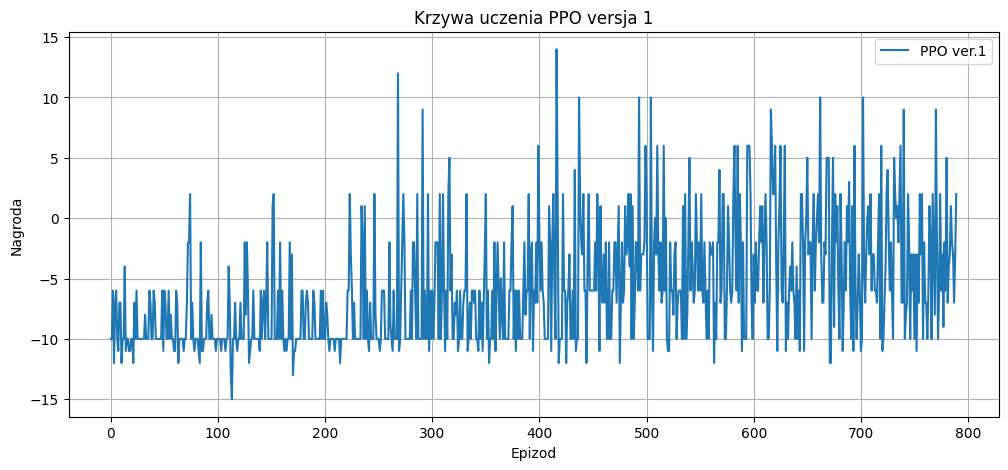

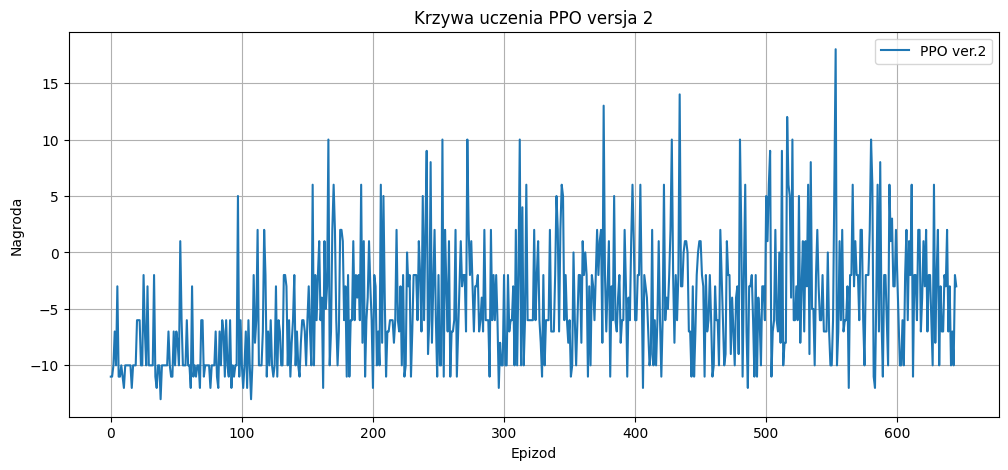

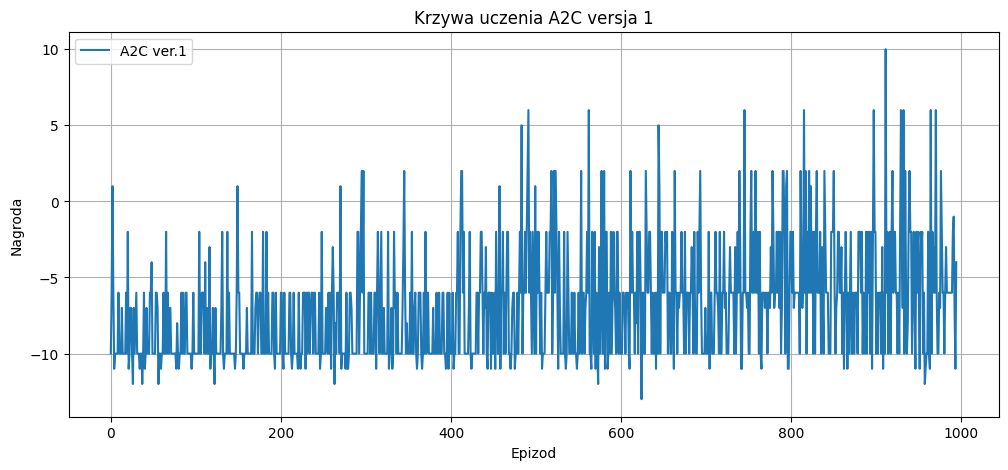

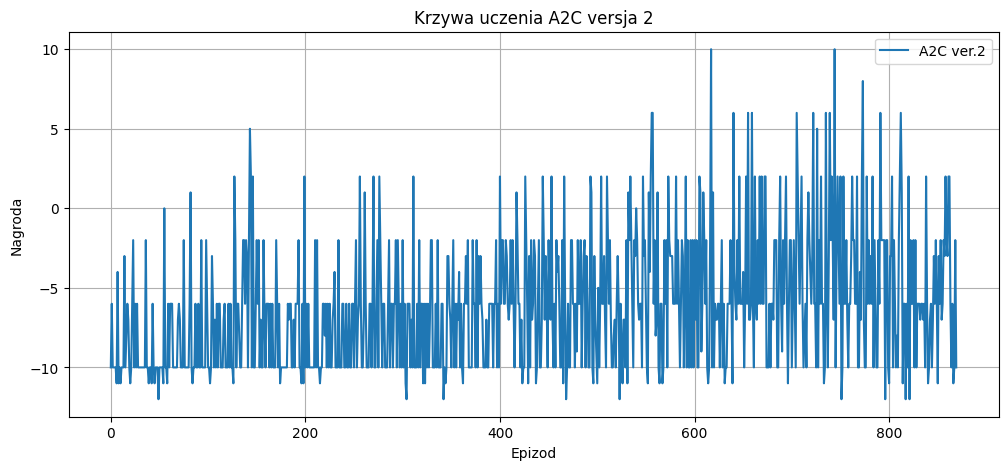

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from gymnasium import spaces, Env
from pettingzoo.utils.env import ParallelEnv
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.env_util import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
import random

# --- Środowisko WarEnvParallel ---
class WarEnvParallel(ParallelEnv):
    metadata = {"render_modes": ["human"]}

    def __init__(self):
        self.hand_size = 10
        self.max_card = 20
        self.possible_agents = ["agent_0", "agent_1"]
        self.agents = self.possible_agents[:]
        self.render_mode = None
        self.observation_spaces = {
            agent: spaces.Dict({
                "observation": spaces.MultiBinary(self.max_card),
                "action_mask": spaces.MultiBinary(self.max_card)
            }) for agent in self.possible_agents
        }
        self.action_spaces = {
            agent: spaces.Discrete(self.max_card)
            for agent in self.possible_agents
        }

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        deck = np.random.permutation(np.tile(np.arange(self.max_card), 2))
        self.hands = {
            "agent_0": sorted(deck[:self.hand_size].tolist()),
            "agent_1": sorted(deck[self.hand_size:self.hand_size * 2].tolist())
        }
        self.round = 0
        self.done = False
        self.scores = {agent: 0 for agent in self.possible_agents}
        self.agents = self.possible_agents[:]
        return self._get_obs()

    def _get_obs(self):
        obs = {}
        for agent in self.possible_agents:
            mask = np.zeros(self.max_card, dtype=np.int8)
            vector = np.zeros(self.max_card, dtype=np.int8)
            for card in self.hands[agent]:
                vector[card] = 1
                mask[card] = 1
            obs[agent] = {"observation": vector, "action_mask": mask}
        return obs

    def step(self, actions):
        if self.done:
            return {}, {}, {}, {}
        rewards = {agent: 0 for agent in self.possible_agents}
        dones = {agent: False for agent in self.possible_agents}
        infos = {agent: {} for agent in self.possible_agents}
        card_0 = actions["agent_0"]
        card_1 = actions["agent_1"]
        if card_0 not in self.hands["agent_0"] or card_1 not in self.hands["agent_1"]:
            self.done = True
            dones = {a: True for a in self.possible_agents}
            return self._get_obs(), {a: -10 for a in self.possible_agents}, dones, infos
        self.hands["agent_0"].remove(card_0)
        self.hands["agent_1"].remove(card_1)
        if card_0 > card_1:
            rewards["agent_0"] = 4
            rewards["agent_1"] = -1
        elif card_1 > card_0:
            rewards["agent_1"] = 4
            rewards["agent_0"] = -1
        self.scores["agent_0"] += rewards["agent_0"]
        self.scores["agent_1"] += rewards["agent_1"]
        self.round += 1
        if self.round >= self.hand_size:
            self.done = True
            dones = {a: True for a in self.possible_agents}
        print(f"\n--- Runda {self.round} ---")
        print(f"Zagrane karty: agent_0 -> {card_0}, agent_1 -> {card_1}")
        print(f"Karty na ręce po tej rundzie:")
        print(f"agent_0: {sorted(self.hands['agent_0'])}")
        print(f"agent_1: {sorted(self.hands['agent_1'])}")
        print(f"Aktualne wyniki: {self.scores}")

        return self._get_obs(), rewards, dones, infos

    def render(self):
        print(f"Scores: {self.scores}")

# --- Pojedynczy agent jako środowisko ---
class SingleAgentEnv(Env):
    def __init__(self, agent_id, opponent_policy):
        super().__init__()
        self.env = WarEnvParallel()
        self.agent_id = agent_id
        self.opponent_id = "agent_1" if agent_id == "agent_0" else "agent_0"
        self.observation_space = spaces.Dict({
            "observation": spaces.MultiBinary(20),
            "action_mask": spaces.MultiBinary(20)
        })
        self.action_space = spaces.Discrete(20)
        self.opponent_policy = opponent_policy

    def reset(self, seed=None, options=None):
        obs = self.env.reset(seed=seed)
        return obs[self.agent_id], {}

    def step(self, action):
        obs = self.env._get_obs()
        opponent_mask = obs[self.opponent_id]["action_mask"]
        legal_actions = [i for i, allowed in enumerate(opponent_mask) if allowed]
        opponent_action = self.opponent_policy(legal_actions)
        actions = {
            self.agent_id: action,
            self.opponent_id: opponent_action
        }
        obs, rewards, dones, infos = self.env.step(actions)
        return obs[self.agent_id], rewards[self.agent_id], dones[self.agent_id], False, {}

    def render(self):
        self.env.render()

# --- Callback do logowania nagród ---
class RewardLoggingCallback(BaseCallback):
    def __init__(self):
        super().__init__()
        self.episode_rewards = []
        self._current_rewards = 0

    def _on_step(self) -> bool:
        self._current_rewards += self.locals['rewards'][0]
        done = self.locals['dones'][0]
        if done:
            self.episode_rewards.append(self._current_rewards)
            self._current_rewards = 0
        return True

# --- Funkcja treningowa ---
def train_model(agent_id, algo, hyperparams, total_timesteps=2000):
    def random_policy(legal_actions):
        return random.choice(legal_actions)

    env = DummyVecEnv([lambda: SingleAgentEnv(agent_id, random_policy)])

    if algo == "ppo":
        model = PPO("MultiInputPolicy", env, verbose=0, **hyperparams)
    elif algo == "a2c":
        model = A2C("MultiInputPolicy", env, verbose=0, **hyperparams)
    else:
        raise ValueError("Unsupported algorithm")

    reward_logger = RewardLoggingCallback()
    model.learn(total_timesteps=total_timesteps, callback=reward_logger)
    model.save(f"{algo}_{agent_id}_{hyperparams['learning_rate']}_{hyperparams['n_steps']}")

    return reward_logger.episode_rewards

# --- Zestawy hiperparametrów ---
ppo_params_1 = {"learning_rate": 0.003, "n_steps": 64}
ppo_params_2 = {"learning_rate": 0.01, "n_steps": 32}

a2c_params_1 = {"learning_rate": 0.005, "n_steps": 35}
a2c_params_2 = {"learning_rate": 0.003, "n_steps": 20}

# --- Trening ---
rewards_ppo_1 = train_model("agent_0", "ppo", ppo_params_1)
rewards_ppo_2 = train_model("agent_0", "ppo", ppo_params_2)

rewards_a2c_1 = train_model("agent_1", "a2c", a2c_params_1)
rewards_a2c_2 = train_model("agent_1", "a2c", a2c_params_2)

plt.figure(figsize=(12, 5))
plt.plot(rewards_ppo_1, label="PPO ver.1")
plt.xlabel("Epizod")
plt.ylabel("Nagroda")
plt.title("Krzywa uczenia PPO versja 1")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(rewards_ppo_2, label="PPO ver.2")
plt.xlabel("Epizod")
plt.ylabel("Nagroda")
plt.title("Krzywa uczenia PPO versja 2")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(rewards_a2c_1, label="A2C ver.1")
plt.xlabel("Epizod")
plt.ylabel("Nagroda")
plt.title("Krzywa uczenia A2C versja 1")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(rewards_a2c_2, label="A2C ver.2")
plt.xlabel("Epizod")
plt.ylabel("Nagroda")
plt.title("Krzywa uczenia A2C versja 2")
plt.legend()
plt.grid(True)
plt.show()


In [135]:
def load_model(algo, agent_id, params):
    filename = f"{algo}_{agent_id}_{params['learning_rate']}_{params['n_steps']}"
    if algo == "ppo":
        return PPO.load(filename)
    elif algo == "a2c":
        return A2C.load(filename)
    else:
        raise ValueError("Unknown algorithm")

def play_match(model1, model1_id, model2, model2_id, rounds=5):
    wins = {model1_id: 0, model2_id: 0}
    print(f"\n=== MATCH: {model1_id} vs {model2_id} ===")
    for i in range(rounds):
        env = WarEnvParallel()
        obs = env.reset(seed=i)
        done = False
        total_rewards = {"agent_0": 0, "agent_1": 0}
        print(f"\n-- Game {i+1} --")
        while not done:
            obs_dict = obs
            obs_0 = obs_dict["agent_0"]
            obs_1 = obs_dict["agent_1"]
            action_mask_0 = obs_0["action_mask"]
            action_mask_1 = obs_1["action_mask"]
            obs_0_input = {"observation": obs_0["observation"], "action_mask": action_mask_0}
            obs_1_input = {"observation": obs_1["observation"], "action_mask": action_mask_1}
            action_0 = model1.predict(obs_0_input, deterministic=True)[0]
            action_1 = model2.predict(obs_1_input, deterministic=True)[0]

            obs, rewards, dones, infos = env.step({
                "agent_0": action_0,
                "agent_1": action_1
            })

            total_rewards["agent_0"] += rewards["agent_0"]
            total_rewards["agent_1"] += rewards["agent_1"]
            done = dones["agent_0"]

            print(f"Round: action0={action_0}, action1={action_1}, rewards={rewards}")

        winner = model1_id if total_rewards["agent_0"] > total_rewards["agent_1"] else model2_id
        wins[winner] += 1
        print(f"Result: {model1_id}={total_rewards['agent_0']} | {model2_id}={total_rewards['agent_1']}")
        print(f"Winner: {winner}")
    print(f"\nFinal score after {rounds} games: {model1_id} won {wins[model1_id]} times, {model2_id} won {wins[model2_id]} times")
    return wins

In [ ]:
models_info = [
    ("ppo", "agent_0", ppo_params_1, "PPO v1"),
    ("ppo", "agent_0", ppo_params_2, "PPO v2"),
    ("a2c", "agent_1", a2c_params_1, "A2C v1"),
    ("a2c", "agent_1", a2c_params_2, "A2C v2"),
]

loaded_models = []
for algo, agent_id, params, label in models_info:
    model = load_model(algo, agent_id, params)
    loaded_models.append((model, label))

# rozgrywki
results = {}
for i in range(len(loaded_models)):
    for j in range(i + 1, len(loaded_models)):
        model1, label1 = loaded_models[i]
        model2, label2 = loaded_models[j]
        result = play_match(model1, label1, model2, label2, rounds=5)
        results[(label1, label2)] = result

print("\n=== PODSUMOWANIE ===")
for (label1, label2), result in results.items():
    total_games = result[label1] + result[label2]
    win_rate1 = result[label1] / total_games * 100
    win_rate2 = result[label2] / total_games * 100
    print(f"{label1} vs {label2}: {label1} win rate = {win_rate1:.2f}%, {label2} win rate = {win_rate2:.2f}%")



=== MATCH: PPO v1 vs PPO v2 ===

-- Game 1 --

--- Runda 1 ---
Zagrane karty: agent_0 -> 18, agent_1 -> 10
Karty na ręce po tej rundzie:
agent_0: [0, 2, 4, 5, 8, 9, 10, 11, 15]
agent_1: [2, 7, 8, 14, 15, 16, 16, 17, 19]
Aktualne wyniki: {'agent_0': 4, 'agent_1': -1}
Round: action0=18, action1=10, rewards={'agent_0': 4, 'agent_1': -1}

--- Runda 2 ---
Zagrane karty: agent_0 -> 15, agent_1 -> 19
Karty na ręce po tej rundzie:
agent_0: [0, 2, 4, 5, 8, 9, 10, 11]
agent_1: [2, 7, 8, 14, 15, 16, 16, 17]
Aktualne wyniki: {'agent_0': 3, 'agent_1': 3}
Round: action0=15, action1=19, rewards={'agent_0': -1, 'agent_1': 4}

--- Runda 3 ---
Zagrane karty: agent_0 -> 5, agent_1 -> 17
Karty na ręce po tej rundzie:
agent_0: [0, 2, 4, 8, 9, 10, 11]
agent_1: [2, 7, 8, 14, 15, 16, 16]
Aktualne wyniki: {'agent_0': 2, 'agent_1': 7}
Round: action0=5, action1=17, rewards={'agent_0': -1, 'agent_1': 4}
Round: action0=15, action1=8, rewards={'agent_0': -10, 'agent_1': -10}
Result: PPO v1=-8 | PPO v2=-3
Winner: P